<a href="https://colab.research.google.com/github/anwishn/ESAA_OB_23-1/blob/main/0505_hw_%ED%85%8D%EC%8A%A4%ED%8A%B8%EB%B6%84%EC%84%9D3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 07. 문서 군집화 소개와 실습(Opinion Review 데이터 세트)



---



### 문서 군집화 개념

**문서 군집화** : 비슷한 텍스트 구성의 문서를 군집화하는 것. 동일한 군집에 속하는 문서를 같은 카테고리 소속으로 분류

* 학습 데이터 세트가 필요없는 비지도학습 기반으로 동장(<->텍스트 분류 기반의 문서 분류 : 사전에 결정 카테고리 값을 가진 학습 데이터 세트 필요)

### Opinion Review 데이터 세트를 이용한 문서 군집화 수행하기

In [ ]:
import pandas as pd
import glob, os

# 디렉터리 다시 설정
path = r'/content/drive/MyDrive/data/topics'
# path로 지정한 디렉터리 밑에 있는 모든 .data 파일의 파일명을 리스트로 취합.
all_files=glob.glob(os.path.join(path, '*.data'))
filename_list=[]
opinion_text=[]

# 개별 파일의 파일명은 filename_list로 취합,
# 개별 파일의 파일 내용은 DataFrame 로딩 후 다시 string으로 변환해 opinion_text list로 취합
for file_ in all_files:
  # 개별 파일을 읽어서 DataFrame으로 생성
  df=pd.read_table(file_, index_col=None, header=0, encoding='latin1')

  # 절대 경로로 주어진 파일명을 가공. 리눅스에서 수행할 때는 다음 \\를 /로 변경.
  # 맨 마지막 .data 확장자도 제거
  filename_ = file_.split('/')[-1]
  filename = filename_.split('.')[0]

  # 파일명 list와 파일 내용 list에 파일명과 파일 내용을 추가.
  filename_list.append(filename)
  opinion_text.append(df.to_string())

# 파일명 list와 파일 내용 list 객체를 DataFrame으로 생성
document_df=pd.DataFrame({'filename':filename_list, 'opinion_text':opinion_text})
document_df.head()

,filename,opinion_text
0,battery-life_amazon_kindle,...
1,comfort_toyota_camry_2007,...
2,accuracy_garmin_nuvi_255W_gps,...
3,battery-life_netbook_1005ha,...
4,comfort_honda_accord_2008,...


* 문서를 TF-IDF 형태로 피처 벡터화

In [ ]:
from nltk.stem import WordNetLemmatizer
import nltk
import string

# 단어 원형 추출 함수
lemmar = WordNetLemmatizer()
def LemTokens(tokens):
    return [lemmar.lemmatize(token) for token in tokens]

# 특수 문자 사전 생성: {33: None ...}
# ord(): 아스키 코드 생성
remove_punct_dict = dict((ord(punct), None) for punct in string.punctuation)

# 특수 문자 제거 및 단어 원형 추출
def LemNormalize(text):
    # 텍스트 소문자 변경 후 특수 문자 제거
    text_new = text.lower().translate(remove_punct_dict)
    
    # 단어 토큰화
    word_tokens = nltk.word_tokenize(text_new)
    
    # 단어 원형 추출
    return LemTokens(word_tokens)

In [ ]:
nltk.download('punkt')
nltk.download('wordnet')

from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vect = TfidfVectorizer(tokenizer=LemNormalize, stop_words='english',
                             ngram_range=(1,2), min_df=0.05, max_df=0.85)    # 범위 설정해 피처 개수 제한
# opinion_text 칼럼 값으로 피처 벡터화 수행
feature_vect = tfidf_vect.fit_transform(document_df['opinion_text'])   # 개별 문서 텍스트에 대해 TF-IDF 변환된 피처 벡터화된 행렬

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn(


* 군집화 K-평균 적용
  + 5개의 중심(Centroid) 기반
  + KMeans 수행 후 군집의 Label값과 중심별로 할당된 데이터 세트의 좌표 값

In [ ]:
from sklearn.cluster import KMeans

# 5개 집합으로 군집화 수행.
km_cluster = KMeans(n_clusters=5, max_iter=10000, random_state=0)
km_cluster.fit(feature_vect)
cluster_label = km_cluster.labels_
cluster_centers = km_cluster.cluster_centers_

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


* 각 데이터별로 할당된 군집의 레이블을 'cluster_label'칼럼을 추가해 저장.
  + 각 파일명은 의견 리뷰에 대한 주제

In [ ]:
document_df['cluster_label'] = cluster_label
document_df.head()

,filename,opinion_text,cluster_label
0,battery-life_amazon_kindle,...,1
1,comfort_toyota_camry_2007,...,0
2,accuracy_garmin_nuvi_255W_gps,...,2
3,battery-life_netbook_1005ha,...,1
4,comfort_honda_accord_2008,...,0


* sort_values(by=정렬칼럼명) 수행해 '정렬칼럼명'으로 데이터 정렬

In [ ]:
# cluster_label=0인 데이터 세트 : 호텔에 대한 리뷰로 군집화
document_df[document_df['cluster_label']==0].sort_values(by='filename')

,filename,opinion_text,cluster_label
4,comfort_honda_accord_2008,...,0
1,comfort_toyota_camry_2007,...,0
46,gas_mileage_toyota_camry_2007,...,0
12,interior_honda_accord_2008,...,0
39,interior_toyota_camry_2007,...,0
14,mileage_honda_accord_2008,...,0
32,performance_honda_accord_2008,...,0
48,quality_toyota_camry_2007,...,0
50,seats_honda_accord_2008,...,0
38,transmission_toyota_camry_2007,...,0


In [ ]:
# cluster_label=1인 데이터 세트 : 포터블 전자기기에 대한 리뷰로 군집화
document_df[document_df['cluster_label']==1].sort_values(by='filename')

,filename,opinion_text,cluster_label
0,battery-life_amazon_kindle,...,1
7,battery-life_ipod_nano_8gb,...,1
3,battery-life_netbook_1005ha,...,1
6,buttons_amazon_kindle,...,1
30,performance_netbook_1005ha,...,1
17,price_amazon_kindle,...,1
26,speed_windows7,...,1


In [ ]:
# cluster_label=2인 데이터 세트 : 대부분 차량용 네비게이션에 대한 리뷰로 군집화
document_df[document_df['cluster_label']==2].sort_values(by='filename')

,filename,opinion_text,cluster_label
2,accuracy_garmin_nuvi_255W_gps,...,2
5,directions_garmin_nuvi_255W_gps,...,2
16,display_garmin_nuvi_255W_gps,...,2
25,satellite_garmin_nuvi_255W_gps,...,2
34,speed_garmin_nuvi_255W_gps,...,2
18,updates_garmin_nuvi_255W_gps,...,2


In [ ]:
# cluster_label=3인 데이터 세트 : 대부분 호텔에 대한 리뷰로 군집화
document_df[document_df['cluster_label']==3].sort_values(by='filename')

,filename,opinion_text,cluster_label
8,bathroom_bestwestern_hotel_sfo,...,3
41,food_holiday_inn_london,...,3
40,food_swissotel_chicago,...,3
35,free_bestwestern_hotel_sfo,...,3
27,location_bestwestern_hotel_sfo,...,3
29,location_holiday_inn_london,...,3
42,parking_bestwestern_hotel_sfo,...,3
44,price_holiday_inn_london,...,3
28,room_holiday_inn_london,...,3
36,rooms_bestwestern_hotel_sfo,...,3


In [ ]:
# cluster_label=4인 데이터 세트 : 자동차에 대한 리뷰로 군집화
document_df[document_df['cluster_label']==4].sort_values(by='filename')

,filename,opinion_text,cluster_label
49,eyesight-issues_amazon_kindle,...,4
33,features_windows7,...,4
13,fonts_amazon_kindle,...,4
21,keyboard_netbook_1005ha,...,4
24,navigation_amazon_kindle,...,4
19,screen_garmin_nuvi_255W_gps,...,4
10,screen_ipod_nano_8gb,...,4
45,screen_netbook_1005ha,...,4
23,size_asus_netbook_1005ha,...,4
43,sound_ipod_nano_8gb,headphone jack i got a clear case for it a...,4


* 중심 개수를 5개에서 3개로 낮춰서 3개 그룹으로 군집화

In [ ]:
from sklearn.cluster import KMeans

# 3개의 집합으로 군집화
km_cluster = KMeans(n_clusters=3, max_iter=10000, random_state=0)
km_cluster.fit(feature_vect)
cluster_label = km_cluster.labels_
cluster_centers = km_cluster.cluster_centers_

# 소속 군집을 cluster_label 칼럼으로 할당하고 cluster_label 값으로 정렬
document_df['cluster_label'] = cluster_label
document_df.sort_values(by='cluster_label')

,filename,opinion_text,cluster_label
0,battery-life_amazon_kindle,...,0
45,screen_netbook_1005ha,...,0
43,sound_ipod_nano_8gb,headphone jack i got a clear case for it a...,0
34,speed_garmin_nuvi_255W_gps,...,0
33,features_windows7,...,0
31,video_ipod_nano_8gb,...,0
30,performance_netbook_1005ha,...,0
26,speed_windows7,...,0
49,eyesight-issues_amazon_kindle,...,0
24,navigation_amazon_kindle,...,0


=> cluster #0은 포터블 전자기기 리뷰로만, cluster #1도 호텔 리뷰로만, cluster #2 역시 자동차 리뷰로만 군집이 잘 구성

### 군집별 핵심 단어 추출하기

각 군집(Cluster)에 속한 문서는 핵심 단어를 주축으로 군집화돼 있을 것

* KMeans 객체는 각 군집을 구성하는 단어 피처가 군집의 중심(Centroid)을 기준으로 얼마나 가깝게 위치해 있는지 **cluster_centers_**라는 속성 제공
  + 배열 값으로 제공. 행은 개별 군집, 열은 개별 피처 의미
  + 각 배열 내의 값은 개별 군집 내의 상대 위치를 숫자 값으로 표현한 일종의 좌표 값

In [ ]:
cluster_centers = km_cluster.cluster_centers_
print('cluster_centers shape :', cluster_centers.shape)
print(cluster_centers)

cluster_centers shape : (3, 4611)
[[0.01005322 0.         0.         ... 0.00706287 0.         0.        ]
 [0.         0.00099499 0.00174637 ... 0.         0.00183397 0.00144581]
 [0.         0.00092551 0.         ... 0.         0.         0.        ]]


=> 각 행의 배열값은 0에서 1까지의 값 가질 수 있으며 1에 가까울수록 중심과 가까운 값 의미

* cluster_centers_ 속성값 이용해 각 군집별 핵심 단어 찾기
  + ndarray의 argsort()[:, ::-1] 이용해 배열 내 값이 큰 순으로 정렬된 위치 인덱스 값 반환(핵심 단어 피처의 이름 출력하기 위해)
  + 해당 인덱스 이용해 핵심 단어 이름과 그때의 상대 위치 값 추출

In [ ]:
#군집별 top n 핵심 단어, 그 단어의 중심 위치 상댓값, 대상 파일명을 반환함.
def get_cluster_details(cluster_model, cluster_data, feature_names, clusters_num, top_n_features=10):
  cluster_details={}

  #cluster_centers array 값이 큰 순으로 정렬된 인덱스 값을 반환
  #군집 중심점 별 할당된 word 피처들의 거리값이 큰 순으로 값을 구하기 위함
  centroid_feature_ordered_ind=cluster_model.cluster_centers_.argsort()[:, ::-1]

  #개별 군집별로 반복하며 핵심 단어, 그 단어의 중심 위치 상댓값, 대상 파일명 입력
  for cluster_num in range(clusters_num):
    #개별 군집별 정보를 담을 데이터 초기화
    cluster_details[cluster_num]={}
    cluster_details[cluster_num]['cluster']=cluster_num

    #cluster_centers_.argsort()로 구한 인덱스를 이용해 top n 피처 단어를 구함
    top_feature_indexes=centroid_feature_ordered_ind[cluster_num, :top_n_features]
    top_features=[feature_names[ind] for ind in top_feature_indexes]

    #top_feature_indexes를 이용해 해당 피처 단어의 중심 위치 상댓값 구함.
    top_feature_values=cluster_model.cluster_centers_[cluster_num, top_feature_indexes].tolist()

    #cluster_details 딕셔너리 객체에 개별 군집별 핵심단어와 중심위치 상댓값, 해당 파일명 입력
    cluster_details[cluster_num]['top_features']=top_features
    cluster_details[cluster_num]['top_features_value']=top_feature_values
    filenames=cluster_data[cluster_data['cluster_label']==cluster_num]['filename']
    filenames=filenames.values.tolist()

    cluster_details[cluster_num]['filenames']=filenames

  return cluster_details

* get_cluster_details() 호출하면 반환하는 cluster_details에는 개별 군집번호, 핵심 단어, 핵심단어 중심 위치 상댓값, 파일명 속성 값 정보 -> 보기 좋게 표현하고자 print_cluster_details() 함수

In [ ]:
def print_cluster_details(cluster_details):
  for cluster_num, cluster_detail in cluster_details.items():
    print('####### Cluster {0}'.format(cluster_num))
    print('Top features:', cluster_detail['top_features'])
    print('Reviews 파일명 :', cluster_detail['filenames'][:7])
    print('===============================================')

* get_cluster_details(), print_cluster_details() 호출
  + get_cluster_details() 호출 시 인자는 KMeans 군집화 객체, 파일명 추출을 위한 document_df DataFrame, 핵심 단어 추출을 위한 피처명 리스트, 전체 군집 개수, 핵심 단어 추출 개수

In [ ]:
feature_names = tfidf_vect.get_feature_names_out()
cluster_details = get_cluster_details(cluster_model = km_cluster, cluster_data = document_df,
                                      feature_names = feature_names, clusters_num = 3, top_n_features = 10)
print_cluster_details(cluster_details)

####### Cluster 0
Top features: ['screen', 'battery', 'keyboard', 'battery life', 'life', 'kindle', 'direction', 'video', 'size', 'voice']
Reviews 파일명 : ['battery-life_amazon_kindle', 'accuracy_garmin_nuvi_255W_gps', 'battery-life_netbook_1005ha', 'directions_garmin_nuvi_255W_gps', 'buttons_amazon_kindle', 'battery-life_ipod_nano_8gb', 'voice_garmin_nuvi_255W_gps']
####### Cluster 1
Top features: ['room', 'hotel', 'service', 'staff', 'food', 'location', 'bathroom', 'clean', 'price', 'parking']
Reviews 파일명 : ['bathroom_bestwestern_hotel_sfo', 'rooms_swissotel_chicago', 'staff_bestwestern_hotel_sfo', 'service_swissotel_hotel_chicago', 'service_holiday_inn_london', 'location_bestwestern_hotel_sfo', 'room_holiday_inn_london']
####### Cluster 2
Top features: ['interior', 'seat', 'mileage', 'comfortable', 'gas', 'gas mileage', 'transmission', 'car', 'performance', 'quality']
Reviews 파일명 : ['comfort_toyota_camry_2007', 'comfort_honda_accord_2008', 'interior_honda_accord_2008', 'mileage_honda_

=> 포터블 전자제품 리뷰 군집인 Cluster #0에서는 화면과 배터리 수명 등이 핵심단어로 군집화. 호텔 리뷰 군집인 Cluster #1에서는 방과 서비스 등이 핵심 단어로 군집화. 자동차 리뷰 군집인 Cluster #2에서는 실내 인테리어, 좌석, 연료 효율 등이 핵심 단어로 군집화

## 10. 텍스트 분석 실습 - 캐글 Mercari Price Suggestion Challenge



---

Mercari Price Suggestion Challenge : 일본의 대형 온라인 쇼핑몰인 Mercari 사의 제품에 대해 가격 예측하는 과제

* 제공되는 데이터 세트의 속성
  + train_id : 데이터 id
  + name : 제품명
  + item_condition_id : 판매자가 제공하는 제품 상태
  + category_name : 카테고리 명
  + brand_name : 브랜드 이름
  + **price** : 제품 가격. 예측을 위한 타깃 속성(예측해야 할 타깃 값)
  + shipping : 배송비 무료 여부. 1이면 무료(판매자가 지불), 0이면 유료(구매자 지불)
  + item_description : 제품에 대한 설명

* item_description과 같은 텍스트 형태의 비정형 데이터와 다른 정형 속성을 같이 적용해 회귀를 수행한다는 점이 다르다

### 데이터 전처리

* 데이터 간략하게 살펴보기

In [ ]:
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import pandas as pd

mercari_df = pd.read_csv('/content/drive/MyDrive/data/mercari-price-suggestion-challenge/mercari_train.tsv', sep='\t')
print(mercari_df.shape)
mercari_df.head(3)

(1482535, 8)


,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...


=> 1482535개의 레코드 가지고 있는 데이터 세트

* 피처의 타입과 Null 여부 확인

In [ ]:
print(mercari_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1482535 entries, 0 to 1482534
Data columns (total 8 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   train_id           1482535 non-null  int64  
 1   name               1482535 non-null  object 
 2   item_condition_id  1482535 non-null  int64  
 3   category_name      1476208 non-null  object 
 4   brand_name         849853 non-null   object 
 5   price              1482535 non-null  float64
 6   shipping           1482535 non-null  int64  
 7   item_description   1482531 non-null  object 
dtypes: float64(1), int64(3), object(4)
memory usage: 90.5+ MB
None


=> brand_name 칼럼의 경우 매우 많은 Null 값. 가격에 영향을 미치는 중요 요인으로 판단. category_name은 약 6300건의 null 데이터. item_description의 null값은 4건으로 미비 -> 이후에 Null 데이터는 적절한 문자열로 치환

* Target 값인 price 칼럼의 데이터 분포도

<ipython-input-23-12402ca32828>:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train_df, kde=False)


<Axes: xlabel='price'>

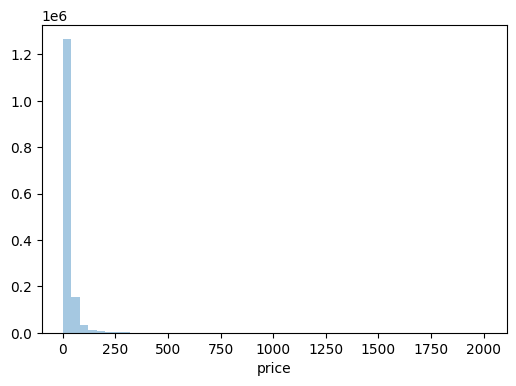

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

y_train_df = mercari_df['price']
plt.figure(figsize=(6,4))
sns.distplot(y_train_df, kde=False)

=> price 값이 비교적 적은 가격을 가진 데이터 값에 왜곡돼 분포

* Price 칼럼을 로그 값으로 변환한 뒤 분포도 다시 확인

<ipython-input-24-73f0fb165241>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train_df, kde=False)


<Axes: xlabel='price'>

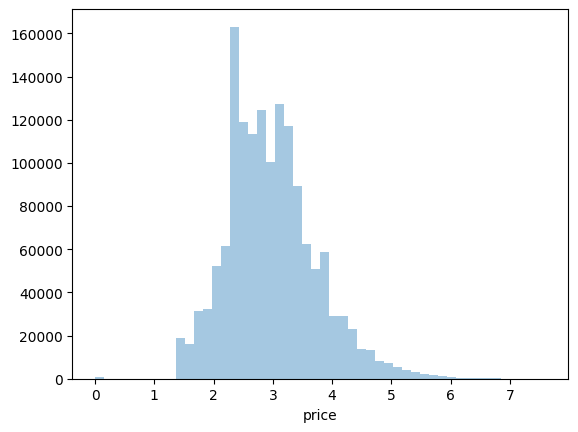

In [ ]:
import numpy as np

y_train_df = np.log1p(y_train_df)
sns.distplot(y_train_df, kde=False)

=> 비교적 정규 분포에 가까운 데이터 이루게 된다

* price 칼럼을 원래 값에서 로그로 변환된 값으로 변경

In [ ]:
mercari_df['price'] = np.log1p(mercari_df['price'])
mercari_df['price'].head(3)

0    2.397895
1    3.970292
2    2.397895
Name: price, dtype: float64

* 다른 피처의 값도 살펴보기 - shipping과 item_condition_id

In [ ]:
print('Shipping 값 유형:\n', mercari_df['shipping'].value_counts())
print('item_condition_id 값 유형:\n', mercari_df['item_condition_id'].value_counts())

Shipping 값 유형:
 0    819435
1    663100
Name: shipping, dtype: int64
item_condition_id 값 유형:
 1    640549
3    432161
2    375479
4     31962
5      2384
Name: item_condition_id, dtype: int64


=> Shipping 칼럼은 배송비 유무이며, 값이 비교적 균일. item_condition_id는 판매자가 제공하는 제품 상태. 1,2,3 값이 주를 이룸.

* item_description 칼럼은 Null값은 별로 없지만, description에 대한 별도 설명이 없는 경우 'No description yet'값으로 돼 있어 -> 얼마나 있는지

In [ ]:
boolean_cond = mercari_df['item_description']=='No description yet'
mercari_df[boolean_cond]['item_description'].count()

82489

=> Null과 마찬가지로 의미 있는 속성값으로는 사용될 수 없어 적절한 값으로 변경해야해

* category_name : '/'로 분리된 카테고리를 하나의 문자열로 나타내 -> '/'를 기준으로 단어를 토큰화해 각각 별도의 피처로 저장하고 알고리즘 학습
  + 대,중,소분류 효과적 분리 위해 split_cat() 함수 생성
    - Null이 아닌 경우에 split('/') 이용
    - Null일 경우에는 error 발생하므로 대,중,소분류 모두 'Other Null'값 부여

In [ ]:
# apply lambda에서 호출되는 대, 중, 소 분할 함수 생성, 대, 중, 소 값을 리스트로 반환
def split_cat(category_name):
  try:
    return category_name.split('/')
  except:
    return ['Other_Null', 'Other_Null', 'Other_Null']

# 위의 split_cat()을 apply lambda에서 호출해 대, 중, 소 칼럼을 mercari_df에 생성.
mercari_df['cat_dae'], mercari_df['cat_jung'], mercari_df['cat_so'] = zip(*mercari_df['category_name'].apply(lambda x : split_cat(x)))

# 대분류만 값의 유형과 건수를 살펴보고, 중분류, 소분류는 값의 유형이 많으므로 분류 개수만 추출
print('대분류 유형 :\n', mercari_df['cat_dae'].value_counts())
print('중분류 개수 :', mercari_df['cat_jung'].nunique())
print('소분류 개수 :', mercari_df['cat_so'].nunique())

대분류 유형 :
 Women                     664385
Beauty                    207828
Kids                      171689
Electronics               122690
Men                        93680
Home                       67871
Vintage & Collectibles     46530
Other                      45351
Handmade                   30842
Sports & Outdoors          25342
Other_Null                  6327
Name: cat_dae, dtype: int64
중분류 개수 : 114
소분류 개수 : 871


* brand_name, category_name, item_description 칼럼의 Null값은 일괄적으로 'Other Null'로 동일하게 변경

In [ ]:
mercari_df['brand_name'] = mercari_df['brand_name'].fillna(value='Other_Null')
mercari_df['category_name'] = mercari_df['category_name'].fillna(value='Other_Null')
mercari_df['item_description'] = mercari_df['item_description'].fillna(value='Other_Null')

In [ ]:
# 각 칼럼별로 Null 값 건수 확인. 모두 0이 나와야 해
mercari_df.isnull().sum()

train_id             0
name                 0
item_condition_id    0
category_name        0
brand_name           0
price                0
shipping             0
item_description     0
cat_dae              0
cat_jung             0
cat_so               0
dtype: int64

### 피처 인코딩과 피처 벡터화

* 선형 회귀 모델과 회귀 트리 모델 모두 적용. 특히 선형 회귀의 경우 원-핫 인코딩 적용이 훨씬 선호되므로 인코딩할 피처는 모두 **원-핫 인코딩** 적용
* 피처 벡터화의 경우는 비교적 짧은 텍스트의 경우는 **Count 기반의 벡터화**, 긴 텍스트는 **TD-IDF 기반의 벡터화** 적용

* brand_name 칼럼 : 상품의 브랜드명

In [ ]:
# 어떤 유형으로 돼 있는지 유형 건수와 대표적인 브랜드명 5개 정도만 살펴보기
print('brand name의 유형 건수 :', mercari_df['brand_name'].nunique())
print('brand name sample 5건 : \n', mercari_df['brand_name'].value_counts()[:5])

brand name의 유형 건수 : 4810
brand name sample 5건 : 
 Other_Null           632682
PINK                  54088
Nike                  54043
Victoria's Secret     48036
LuLaRoe               31024
Name: brand_name, dtype: int64


=> 대부분 명료한 문자열 -> 원-핫 인코딩 변환

* name 칼럼 : 상품명

In [ ]:
# 어떤 유형으로 돼 있는지 유형 건수와 상품명을 7개만 출력
print('name의 종류 개수 :', mercari_df['name'].nunique())
print('name sample 10건 : \n', mercari_df['name'][:10])

name의 종류 개수 : 1225273
name sample 10건 : 
 0       MLB Cincinnati Reds T Shirt Size XL
1          Razer BlackWidow Chroma Keyboard
2                            AVA-VIV Blouse
3                     Leather Horse Statues
4                      24K GOLD plated rose
5          Bundled items requested for Ruie
6        Acacia pacific tides santorini top
7      Girls cheer and tumbling bundle of 7
8                     Girls Nike Pro shorts
9    Porcelain clown doll checker pants VTG
Name: name, dtype: object


=> 유형이 매우 많고, 적은 단어 위주의 텍스트 형태 -> Count 기반의 피처 벡터화 변환 적용

* category_name 칼럼 : 이전 전처리 통해 대, 중, 소 분류 세 개의 칼럼인 cat_dae, cat_jung, cat_so 칼럼으로 분리됨 -> 원-핫 인코딩 적용

* shipping 칼럼 : 배송비 무료 여부. 0과 1 두 가지 유형의 값 -> 원-핫 인코딩 적용
* item_condition_id : 상품 상태. 1,2,3,4,5 다섯 가지 유형의 값 -> 원-핫 인코딩

* item_description : 상품에 대한 간단 설명. 가장 긴 텍스트

In [ ]:
pd.set_option('max_colwidth', 200)

# item_description의 평균 문자열 크기
print('item_description 평균 문자열 크기:', mercari_df['item_description'].str.len().mean())

mercari_df['item_description'][:2]

item_description 평균 문자열 크기: 145.7113889385411


0                                                                                                                                                                              No description yet
1    This keyboard is in great condition and works like it came out of the box. All of the ports are tested and work perfectly. The lights are customizable via the Razer Synapse app on your PC.
Name: item_description, dtype: object

=> 평균 문자열이 145자로 비교적 커 -> TF-IDF 변환

* 주요 칼럼 인코딩 및 피처 벡터화 변환
  + name 칼럼 : CountVectorizer
  + item_description 칼럼 : TfidfVectorizer

In [ ]:
# name 속성에 대한 피처 벡터화 변환
cnt_vec = CountVectorizer()
X_name = cnt_vec.fit_transform(mercari_df.name)

# item_description에 대한 피처 벡터화 변환
tfidf_descp = TfidfVectorizer(max_features = 50000, ngram_range=(1,3), stop_words='english')
X_descp = tfidf_descp.fit_transform(mercari_df['item_description'])

print('name vectorization shape:', X_name.shape)
print('item_description vectorization shape:', X_descp.shape)

name vectorization shape: (1482535, 105757)
item_description vectorization shape: (1482535, 50000)


=> CountVectorizer, TfidfVectorizer가 fit_tranform()을 통해 반환하는 데이터는 희소 행렬 형태

=> 희소 행렬 객체 변수인 X_name과 X_descp 새로 결합해 새로운 데이터 세트로 구성해야 하고, 앞으로 인코딩될 cat_dae, cat_jung, cat_so, brand_name, shipping, item_condition_id도 모두 X_name, X_descp와 결합돼 ML 모델을 실행하는 기반 데이터 세트로 재구성

* 사이킷런은 원-핫 인코딩을 위해 **OneHotEncoder**와 **LabelBinarizer**클래스 제공
  + LabelBinarizer 클래스는 희소 행렬 형태의 원-핫 인코딩 변환 지원. 생성 시 **sparse_out=True**로 파라미터 설정
  + 모든 인코딩 대상 칼럼은 LabelBinarizer 이용해 변환한 후 사이파이 패키지 sparse 모듈의 hstack()함수 이용해 결합

In [ ]:
from sklearn.preprocessing import LabelBinarizer

# brand_name, item_condition_id, shipping 각 피처들을 희소 행렬 원-핫 인코딩 변환
lb_brand_name = LabelBinarizer(sparse_output=True)
X_brand = lb_brand_name.fit_transform(mercari_df['brand_name'])
lb_item_cond_id = LabelBinarizer(sparse_output=True)
X_item_cond_id = lb_item_cond_id.fit_transform(mercari_df['item_condition_id'])
lb_shipping = LabelBinarizer(sparse_output=True)
X_shipping = lb_shipping.fit_transform(mercari_df['shipping'])

# cat_dae, cat_jung, cat_so 각 피처들을 희소 행렬 원-핫 인코딩 변환
lb_cat_dae = LabelBinarizer(sparse_output=True)
X_cat_dae= lb_cat_dae.fit_transform(mercari_df['cat_dae'])
lb_cat_jung = LabelBinarizer(sparse_output=True)
X_cat_jung = lb_cat_jung.fit_transform(mercari_df['cat_jung'])
lb_cat_so = LabelBinarizer(sparse_output=True)
X_cat_so = lb_cat_so.fit_transform(mercari_df['cat_so'])

In [ ]:
# 제대로 변환됐는지 생성된 인코딩 데이터 세트의 타입과 shape 살펴보기
print(type(X_brand), type(X_item_cond_id), type(X_shipping))
print('X_brand_shape:{0}, X_item_cond_id shape:{1}'.format(X_brand.shape, X_item_cond_id.shape))
print('X_shipping shape:{0}, X_cat_dae shape:{1}'.format(X_shipping.shape, X_cat_dae.shape))
print('X_cat_jung shape:{0}, X_cat_so shape:{1}'.format(X_cat_jung.shape, X_cat_so.shape))

<class 'scipy.sparse._csr.csr_matrix'> <class 'scipy.sparse._csr.csr_matrix'> <class 'scipy.sparse._csr.csr_matrix'>
X_brand_shape:(1482535, 4810), X_item_cond_id shape:(1482535, 5)
X_shipping shape:(1482535, 1), X_cat_dae shape:(1482535, 11)
X_cat_jung shape:(1482535, 114), X_cat_so shape:(1482535, 871)


=> 인코딩 변환된 데이터 세트가 CSR 형태로 변환된 csr_matrix 타입

* 피처 벡터화 변환한 데이터 세트와 희소 인코딩 변환한 데이터 세트를 hstack() 이용해 모두 결합
  + 결합 데이터를 del '객체 변수명'과 gc.collect()로 메모리에서 삭제

In [ ]:
from scipy.sparse import hstack
import gc

sparse_matrix_list=(X_name, X_descp, X_brand, X_item_cond_id,
                    X_shipping, X_cat_dae, X_cat_jung, X_cat_so)

X_features_sparse=hstack(sparse_matrix_list).tocsr()
print(type(X_features_sparse), X_features_sparse.shape)

del X_features_sparse
gc.collect()

<class 'scipy.sparse._csr.csr_matrix'> (1482535, 161569)


16

### 릿지 회귀 모델 구축 및 평가

* 평가 지표 : **RMSLE**
* 모델을 평가하는 평가 로직 함수화
  + RMSE와 유사하나 오류 값에 로그를 취해
  + 낮은 가격(price)보다 높은 가격에서 오류가 발생할 경우 오류 값이 더 커지는 것을 억제하기 위해

* 원본 데이터의 price 칼럼 값 왜곡된 데이터 분포 가져 로그 값 취해 정규 분포 형태로 변환 -> 예측도 당연히 로그로 변환한 데이터 값 수준의 price 값 예측할 것
  + => 예측된 price 값은 **다시 로그의 역변환인 지수 변환**을 수행해 원복해야한다

In [ ]:
def rmsle(y, y_pred):
  # underflow, overflow를 막기 위해 log가 아닌 log1p로 rmsle 계산
  return np.sqrt(np.mean(np.power(np.log1p(y) - np.log1p(y_pred), 2)))

def evaluate_org_price(y_test, preds):

  # 원본 데이터는 log1p로 변환되었으므로 exmpm1로 원복 필요
  preds_exmpm = np.expm1(preds)
  y_test_exmpm = np.expm1(y_test)

  # rmsle로 RMSLE 값 추출
  rmsle_result = rmsle(y_test_exmpm, preds_exmpm)
  return rmsle_result

* 학습용 데이터 생성하고, 모델 학습/예측하는 로직 함수화

In [ ]:
import gc
from scipy.sparse import hstack

def model_train_predict(model, matrix_list):
  # scipy.sparse 모듈의 hstack을 이용해 희소 행렬 결합
  X = hstack(matrix_list).tocsr()

  X_train, X_test, y_train, y_test = train_test_split(X, mercari_df['price'], test_size=0.2, random_state=156)

  # 모델 학습 및 예측
  model.fit(X_train, y_train)
  preds = model.predict(X_test)

  del X, X_train, X_test, y_train
  gc.collect()

  return preds, y_test

* Ridge 이용해 회귀 예측 수행
  + 수행 전에 Mercari 상품 가격 예측에 item_description과 같은 텍스트 형태의 속성이 얼마나 영향을 미치는지 -> 피처 벡터화 데이터가 포함되지 않을 때와 포함됐을 때의 예측 성능 비교

In [ ]:
linear_model = Ridge(solver='lsqr', fit_intercept=False)

sparse_matrix_list = (X_name, X_brand, X_item_cond_id, X_shipping, X_cat_dae, X_cat_jung, X_cat_so)
linear_preds, y_test = model_train_predict(model=linear_model, matrix_list=sparse_matrix_list)
print('Item Description을 제외했을 때 rmsle 값:', evaluate_org_price(y_test, linear_preds))

sparse_matrix_list = (X_descp, X_name, X_brand, X_item_cond_id, X_shipping, X_cat_dae, X_cat_jung, X_cat_so)
linear_preds, y_test = model_train_predict(model=linear_model, matrix_list = sparse_matrix_list)
print('Item Description을 포함한 rmsle 값:', evaluate_org_price(y_test, linear_preds))

Item Description을 제외했을 때 rmsle 값: 0.4983990938999374
Item Description을 포함한 rmsle 값: 0.4680329023962086


=> Item Description 포함했을 때 rmsle 값 많이 감소 -> Item Description 영향 중요함

### LightGBM 회귀 모델 구축과 앙상블을 이용한 최종 예측 평가

* LightGBM 이용해 회귀 수행

In [ ]:
from lightgbm import LGBMRegressor

sparse_matrix_list = (X_descp, X_name, X_brand, X_item_cond_id,
                      X_shipping, X_cat_dae, X_cat_jung, X_cat_so)

lgbm_model = LGBMRegressor(n_estimators=200, learning_rate=0.5, num_leaves=125, random_state=156)
lgbm_preds , y_test = model_train_predict(model = lgbm_model , matrix_list=sparse_matrix_list)
print('LightGBM rmsle 값:',  evaluate_org_price(y_test , lgbm_preds))

* 릿지 모델 예측값과 LightGBM 모델 예측값을 서로 앙상블해 최종 회귀 예측값 도출

In [ ]:
preds = lgbm_preds * 0.45 + linear_preds * 0.55
print('LightGBM과 Ridge를 ensemble한 최종 rmsle 값:',  evaluate_org_price(y_test , preds))

=> 간단한 앙상블 방식으로 예측 성능 더 개선

## 11. 정리



---


머신러닝 기반의 텍스트 분석 프로세스
1. 텍스트 정규화 작업 : 텍스트 클렌징 및 대소문자 변경, 단어 토큰화, 의미 없는 단어 필터링, 어근 추출 등 다양한 사전 작업
2. 피처 벡터화 변환 : BOW의 대표 방식인 Count 기반과 TF-IDF 기반 피처 벡터화(TF-IDF 기반의 피처 벡터가 더 정확한 결과 도출)
3. 생성된 피처 벡터 데이터 세트는 희소 행렬 -> 머신러닝 모델 학습하고 예측, 평가